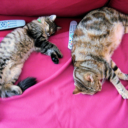

In [1]:
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw) # PIL image of shape HWC
image

from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

image_size = 128

transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(),
    Lambda(lambda t: (t*2)-1) # [-1, 1]
])

x_start = transform(image).unsqueeze(0)
x_start.shape



import numpy as np

reverse_transform = Compose([
    Lambda(lambda t: (t+1)/2),
    Lambda(lambda t: t.permute(1,2,0)),
    Lambda(lambda t: t * 255.),
    Lambda(lambda t: t.numpy().astype(np.uint8)),
    ToPILImage()
])

reverse_transform(x_start.squeeze())

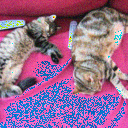

In [12]:
import torch
from inspect import isfunction
from torch import nn, einsum
import torch.nn.functional as F

def exists(x):
    return x is not None

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

timesteps = 300
betas = linear_beta_schedule(timesteps=timesteps)

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# q(x_t|x_{t-1})
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)


def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1, ) * (len(x_shape)-1))).to(t.device)

def q_sample(x_start, t, noise=None):
    noise = default(noise, torch.rand_like(x_start))
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image

# take time step
t = torch.tensor([40])

get_noisy_image(x_start, t)

In [13]:
import matplotlib.pyplot as plt

# use seed for reproducability
torch.manual_seed(0)

# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()


In [14]:
plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])


In [16]:
from datasets import load_dataset

# 加载 Fashion MNIST 数据集
dataset = load_dataset('fashion_mnist')

# 打印数据集的元数据
print(dataset)




Generating test split: 100%|██████████| 10000/10000 [00:01<00:00, 5000.05 examples/s]


AttributeError: 'DatasetDict' object has no attribute 'info'